In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import statistics as stat

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from abc import ABCMeta, abstractmethod

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')

In [2]:
class ProfitVisualize(metaclass=ABCMeta):
    
    '''
    input:
        month_NAV：該月所有淨值
        random_names：基金池的所有基金名
    output:
        整理出的features
        與features對齊的基金名
    '''
    @abstractmethod
    def getFeatures(self, NAV,names):
        pass
    
    '''
    input:回測年
    output:基金池（名字）
    '''
    @abstractmethod
    def poolDecide(self, year):
        pass
    
    def getNAV(self,names,start,end):
        data = pd.read_sql(sql='select * from price where date between ? and ? order by date asc',
                                 con=engine,index_col='date', params=[start,end])
        date = pd.read_sql(sql='select distinct date from price where date between ? and ? order by date asc',
                                 con=engine,index_col='date', params=[start,end]).index
        NAV = np.zeros((len(names),len(date)))
        for j in range (len(names)):
            temp = data[data['id'] == names[j]]
            NAV[j][0] = temp.iloc[0]['NAV']
            for i,day in enumerate(date[1:]):
                try:
                    NAV[j][i+1] = temp.loc[day]['NAV']
                except:
                    NAV[j][i+1] = NAV[j][i]
        return NAV
        
    def __init__(self,clusterStrategy):
        self.clusterStrategy = clusterStrategy
    
    def getProfitPicture(self):
        year = input("請輸入欲回測年：")        
        names = self.poolDecide(year)
        NAV = self.getNAV(names,year+'-01-01',year+'-01-31')
        features,names,dissimilarity = self.getFeatures(NAV,names)
        clustering = ClusterMethod(self.clusterStrategy).startClustering(features)
        
        mds = MDS(n_components=2, dissimilarity=dissimilarity, n_jobs=8).fit(features).embedding_
        plt.figure(figsize=(15, 15))
        plt.subplots_adjust(bottom=0.1)
        plt.scatter(mds[:, 0], mds[:, 1], c=clustering.labels_)
        plt.show()
        
        camp = pd.DataFrame(data=clustering.labels_, index=names,columns=['label'])
        choose_name = []
        for i in range(4):
            choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])
        choose_name.append('0050 元大台灣50')
        
        NAV = self.getNAV(choose_name,year+'-01-01',year+'-12-31')        
        rate = np.zeros((len(choose_name),len(NAV[0])-1))
        for j in range (len(choose_name)):
            for i in range (len(NAV[0])-1):
                rate[j][i] = (NAV[j][i+1] - NAV[j][i]) / NAV[j][i]

        choose_rate = []
        for i in range(len(rate[0])):
            temp = (rate[0][i] + rate[1][i] + rate[2][i] + rate[3][i])/4
            choose_rate.append(temp)
        
        plt.figure(figsize=(13, 13))
        plt.ylabel('漲跌幅')
        plt.title('漲跌幅對比')
        plt.plot(choose_rate)
        plt.plot(rate[-1])
        plt.legend(['choose','compare'])
        plt.show()
        
        choose_profit = []
        compare__profit = []
        start = (NAV[0][0] + NAV[1][0] + NAV[2][0] + NAV[3][0])/4
        for i in range(len(NAV[0])):
            temp = (NAV[0][i] + NAV[1][i] + NAV[2][i] + NAV[3][i])/4
            temp = (temp-start)/start*100
            choose_profit.append(temp)
            compare__profit.append((NAV[4][i]-NAV[4][0])/NAV[4][0]*100)
            
        plt.figure(figsize=(14, 14))
        plt.ylabel('收益率')
        plt.title('收益率對比')
        plt.plot(choose_profit)
        plt.plot(compare__profit)
        plt.legend(['Choose','Compare'])
        plt.show()

In [3]:
class ClusterStrategy(metaclass=ABCMeta):
    @abstractmethod
    def Clustering(self,features):
        pass

In [4]:
class ClusterMethod:
    def __init__(self, clusterStrategy):
        self.clusterStrategy = clusterStrategy
    
    def startClustering(self,features):
        return self.clusterStrategy.Clustering(features)

In [5]:
class K_Means(ClusterStrategy):
    def Clustering(self,features):
        return KMeans(n_clusters=4).fit(features)

In [6]:
class Hierarchical(ClusterStrategy):
    def Clustering(self,features):
        return AgglomerativeClustering(n_clusters=4).fit(features)

# 實作框架

In [7]:
'''
每日漲跌幅
'''
class UpDownRate(ProfitVisualize):

    def getFeatures(self, NAV,names):
        length = len(NAV[0])-1
        rate = np.zeros((len(names),length))
        for j in range (len(names)):
            for i in range (length):
                rate[j][i] = (NAV[j][i+1] - NAV[j][i]) / NAV[j][i]
        return rate,names,'euclidean'
    
    def poolDecide(self,year):
        names = pd.read_sql(sql='select distinct id from price where date between ? and ? order by date asc',
                                 con=engine, params=[year+'-01-01',year+'-01-31'])
#         year = str(int(year)-1)
#         temp = []
#         for i in names.index:
#             try:
#                 price_first = pd.read_sql(sql='select NAV from price where date > ? and id = ? order by date asc limit 1',
#                                              con=engine ,params=[year+'-01-01',names.iloc[i].id]).NAV.values[0]
#                 price_last = pd.read_sql(sql='select NAV from price where date < ? and id = ? order by date desc limit 1',
#                                              con=engine ,params=[year+'-12-31',names.iloc[i].id]).NAV.values[0]
#                 if (price_last-price_first)/price_first <=-0.1:
#                     temp.append(i)
#             except:
#                 temp.append(i)
#         names = names.drop(index=temp,axis=0)
        names = names['id'].sample(n=300).values
        return names

In [14]:
'''
每日漲跌幅相關係數
'''
class UpDownRateSimilarity(ProfitVisualize):
        
    def getFeatures(self, NAV, names):
        length = len(NAV[0])-1
        rate = np.zeros((len(names),length))
        for j in range (len(names)):
            for i in range (length):
                rate[j][i] = (NAV[j][i+1] - NAV[j][i]) / NAV[j][i]        
        temp = []
        for i,j in enumerate(rate):                        
            if np.cov(j) == 0:
                temp.append(i)                
        rate = np.delete(rate,temp,0)
        names = np.delete(names,temp,0)
        
        similarity = np.zeros((len(rate),len(rate)))
        for i in range(len(rate)):
            for j in range(len(rate)):
                corr = np.corrcoef(rate[i],rate[j])[0][-1]
                if i == j:
                    corr = 1
                similarity[i][j] = 1-(corr*0.5+0.5)                
        return similarity,names,'precomputed'
    
    def poolDecide(self,year):
#         year = str(int(year)-1)
        names = pd.read_sql(sql='select distinct id from price where date between ? and ? order by date asc',
                                 con=engine, params=[year+'-01-01',year+'-01-31'])
#         NAV = getNAV(self,names,year+'',end)

        names = names['id'].sample(n=300).values
        return names

In [9]:
'''
平均數
'''
class Mean(ProfitVisualize):
        
    def getFeatures(self, NAV,names):
        features = pd.DataFrame(NAV)
        for i in features:
            features.iloc[i] = (features.iloc[i]-(stat.mean(features.iloc[i].values)))/features.iloc[i]           
        
        return features,names,'euclidean'
    
    def poolDecide(self,year):
        names = pd.read_sql(sql='select distinct id from price where date between ? and ? order by date asc',
                                 con=engine, params=[year+'-01-01',year+'-01-31'])
#         year = str(int(year)-1)
#         temp = []
#         for i in names.index:
#             try:
#                 price_first = pd.read_sql(sql='select NAV from price where date > ? and id = ? order by date asc limit 1',
#                                              con=engine ,params=[year+'-01-01',names.iloc[i].id]).NAV.values[0]
#                 price_last = pd.read_sql(sql='select NAV from price where date < ? and id = ? order by date desc limit 1',
#                                              con=engine ,params=[year+'-12-31',names.iloc[i].id]).NAV.values[0]
#                 if (price_last-price_first)/price_first <=-0.1:
#                     temp.append(i)
#             except:
#                 temp.append(i)
#         names = names.drop(index=temp,axis=0)
        names = names['id'].sample(n=300).values
        return names

In [10]:
'''
平均數相關係數
'''

class MeanSimilarity(ProfitVisualize):
    
    def getFeatures(self, NAV,names):
        features = pd.DataFrame(NAV)
        for i in features:
            features.iloc[i] = (features.iloc[i]-(stat.mean(features.iloc[i].values)))/features.iloc[i]           
        features = features.values
        
        temp = []
        for i,j in enumerate(features):
            if np.cov(j) == 0:
                temp.append(i)       
        features = np.delete(features,temp,0)
        names = np.delete(names,temp,0)
        
        similarity = np.zeros((len(features),len(features)))
        for i in range(len(features)):
            for j in range(len(features)):
                corr = np.corrcoef(features[i],features[j])[0][-1]
                if i == j:
                    corr = 1
                similarity[i][j] = 1-(corr*0.5+0.5)
                
        return similarity,names,'precomputed'
    
    def poolDecide(self,year):
        names = pd.read_sql(sql='select distinct id from price where date between ? and ? order by date asc',
                                 con=engine, params=[year+'-01-01',year+'-01-31'])
#         year = str(int(year)-1)
#         temp = []
#         for i in names.index:
#             try:
#                 price_first = pd.read_sql(sql='select NAV from price where date > ? and id = ? order by date asc limit 1',
#                                              con=engine ,params=[year+'-01-01',names.iloc[i].id]).NAV.values[0]
#                 price_last = pd.read_sql(sql='select NAV from price where date < ? and id = ? order by date desc limit 1',
#                                              con=engine ,params=[year+'-12-31',names.iloc[i].id]).NAV.values[0]
#                 if (price_last-price_first)/price_first <=-0.1:
#                     temp.append(i)
#             except:
#                 temp.append(i)
#         names = names.drop(index=temp,axis=0)
        names = names['id'].sample(n=300).values
        return names

請輸入欲回測年：2017


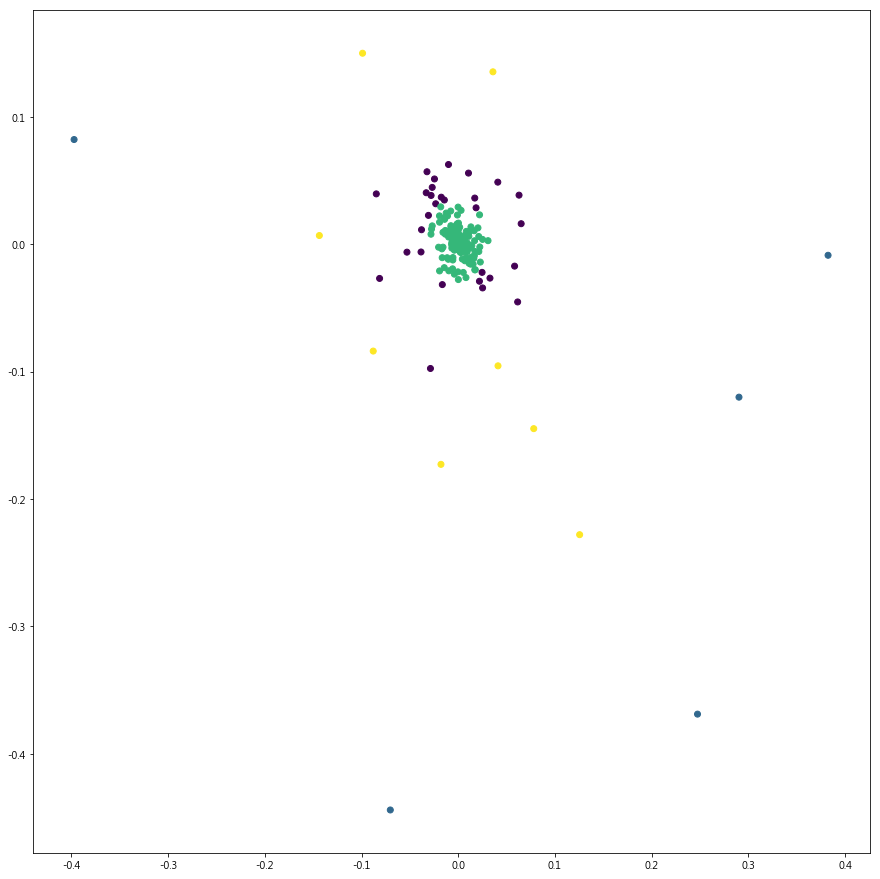

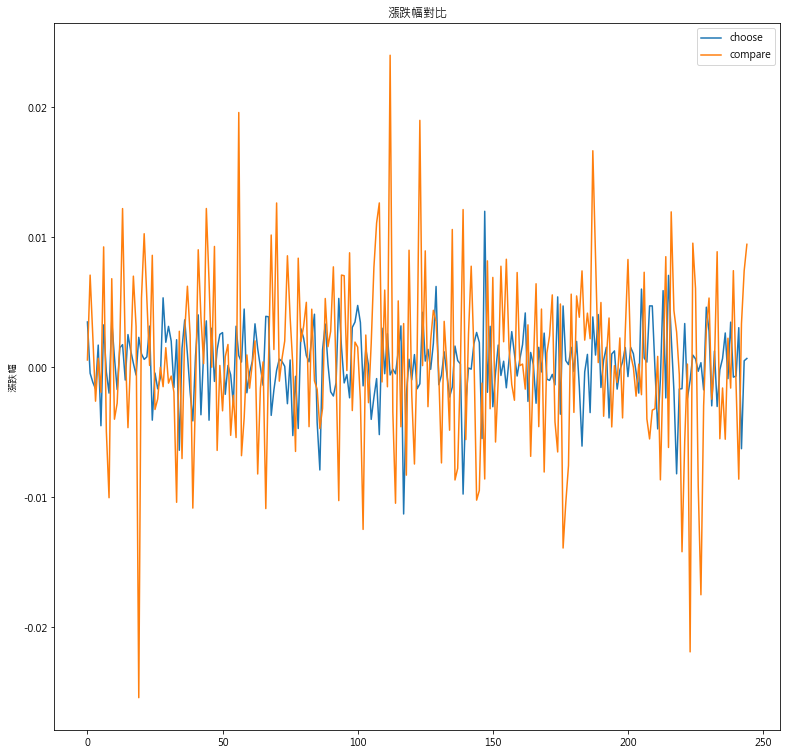

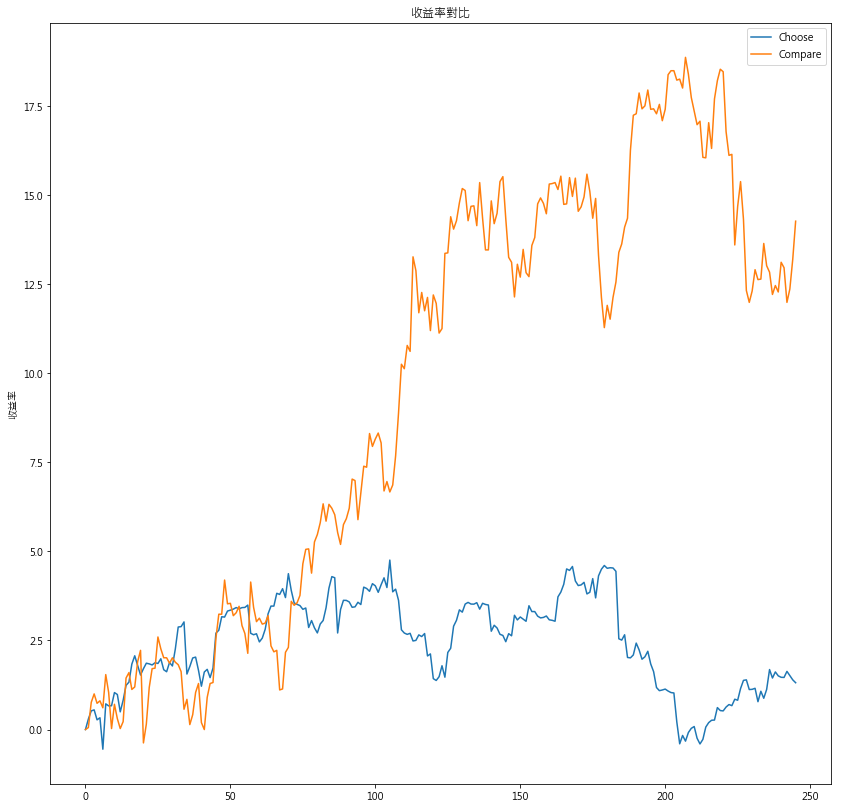

In [12]:
profitVisualize = UpDownRateSimilarity(K_Means())
profitVisualize.getProfitPicture()

請輸入欲回測年：2017


/home/xiangli/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


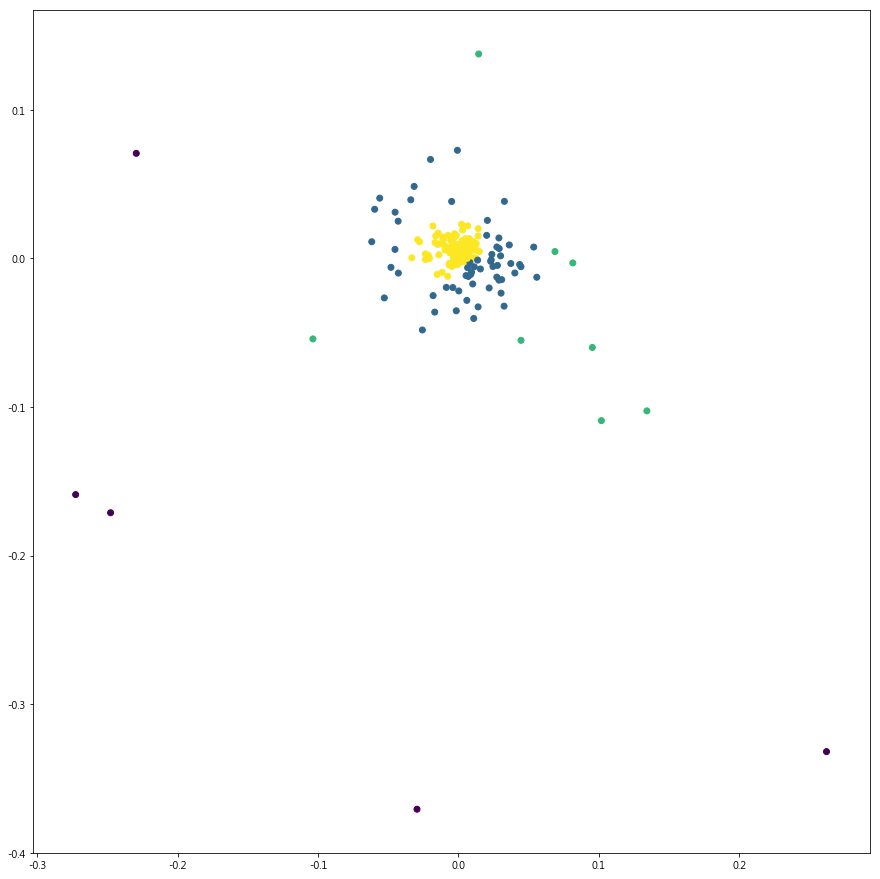

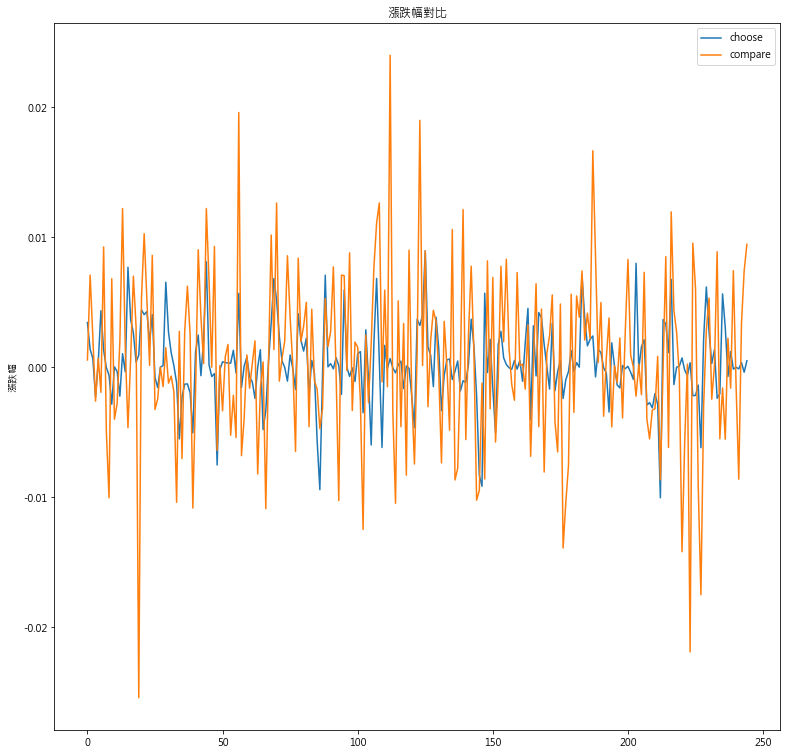

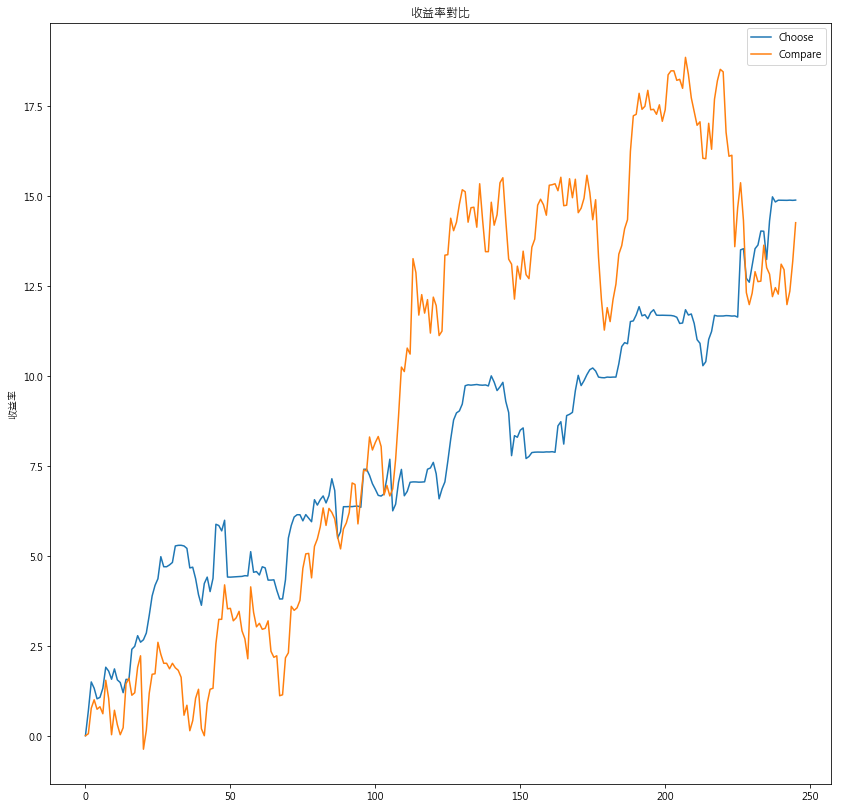

In [13]:
profitVisualize = UpDownRateSimilarity(Hierarchical())
profitVisualize.getProfitPicture()